In [3]:
from torch.optim import lr_scheduler
import os.path
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from torch.utils.data import Dataset
from torch_geometric.utils.convert import from_networkx
import tensorflow_hub as hub
import random
from tqdm import tqdm
from Knowledge.ConceptNet import ConceptNet
import pickle
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizer, BertModel
import torch
from nltk import word_tokenize
import networkx as nx
import copy
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import MessagePassing

## BERT Context Encoder

## Load ConceptNet

In [4]:
conceptnet = ConceptNet('../../Knowledge/Data/', numberbatch=False)

[ConceptNet Constructing] Using GLoVe
[ConceptNet Constructing] Load ConceptNet from file


100%|██████████| 2206782/2206782 [00:12<00:00, 176737.54it/s]


In [57]:
from nltk import PorterStemmer

## Check CUDA Availability

In [44]:
torch.cuda.is_available()

True

## Candidate Filtering Function

In [8]:
def candidate_nodes(graph, start_concepts, hops=2):
    result = []
    for start_concept in start_concepts:
        if graph.has_node(start_concept):
            result.append(start_concept)
    q = copy.deepcopy(result)

    for i in range(hops):
        temp = []
        while len(q) != 0:
            head = q.pop(0)
            adj = list(graph.neighbors(head))
            result.extend(adj)
            temp.extend(adj)
        q = list(set(temp))
    return list(set(result))

In [11]:
'student' in candidate_nodes(global_graph, ['type', 'cuisine'])

True

## BERT

In [46]:
BERT = False
if BERT:
    BERT_model_name = 'bert-base-uncased'
    BERT_tokenizer = BertTokenizer.from_pretrained(BERT_model_name)
    BERT_model = BertModel.from_pretrained(BERT_model_name)
    BERT_model.requires_grad_(False)

    def bert_context(context):
        context = "[CLS] " + context

        # Tokenize and encode the context
        context_tokens = BERT_tokenizer.encode(context, add_special_tokens=True)
        input_ids = torch.tensor(context_tokens).unsqueeze(0)  # Add batch dimension

        # Pass through BERT model
        with torch.no_grad():
            outputs = BERT_model(input_ids)
        context_representation = outputs.last_hidden_state[:, 0, :]
        return context_representation.reshape(-1)

## GCN

In [10]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        y = self.conv1(x, edge_index)
        y = F.relu(y)
        y = self.conv2(y, edge_index)
        return y

In [48]:
class KETransEGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(KETransEGCNConv, self).__init__(aggr='mean', flow="target_to_source")  # Disable built-in aggregation

        self.Ws = nn.Linear(in_channels, out_channels).cuda()
        self.Wn = nn.Linear(in_channels, out_channels).cuda()
        self.Wr = nn.Linear(in_channels, out_channels).cuda()

    def forward(self, x, edge_index, edge_type):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        edge_type = torch.cat((edge_type.cuda(), torch.zeros(x.size(0), edge_type.size(1)).cuda()), 0)
        return self.propagate(edge_index, x=x, edge_type=edge_type)

    def message(self, x_i, x_j, edge_type):
        head = x_i.requires_grad_(True).cuda()
        tail = x_j.requires_grad_(True).cuda()
        rel = edge_type.requires_grad_(True).cuda()

        dist = -(torch.norm(head + rel - tail, p=2, dim=1)**2)
        gradients_head = torch.autograd.grad(dist, head, torch.ones_like(dist).cuda(), retain_graph=True)[0]

        return self.Wn(gradients_head)

    def update(self, aggr_out, x, edge_type):
        new_node_embedding = self.Ws(x.cuda()) + aggr_out.cuda()
        new_edge_type = self.Wr(edge_type.cuda())
        return new_node_embedding, new_edge_type[:new_edge_type.size(0)-new_node_embedding.size(0)]

class KETransEGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(KETransEGCN, self).__init__()  # Disable built-in aggregation

        self.conv1 = KETransEGCNConv(in_channels, hidden_channels)
        self.conv2 = KETransEGCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_type):
        x, edge_type = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x, _ = self.conv2(x, edge_index, edge_type)
        return x

In [49]:
class TransEGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(TransEGCNConv, self).__init__(aggr='mean', flow="target_to_source")  # Disable built-in aggregation

        self.Ws = nn.Linear(in_channels, out_channels).cuda()
        self.Wn = nn.Linear(in_channels, out_channels).cuda()
        self.Wr = nn.Linear(in_channels, out_channels).cuda()

    def forward(self, x, edge_index, edge_type):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        edge_type = torch.cat((edge_type.cuda(), torch.zeros(x.size(0), edge_type.size(1)).cuda()), 0)
        return self.propagate(edge_index, x=x, edge_type=edge_type)

    def message(self, x_j, edge_type):
        return self.Wn(x_j - edge_type)

    def update(self, aggr_out, x, edge_type):
        new_node_embedding = self.Ws(x.cuda()) + aggr_out.cuda()
        new_edge_type = self.Wr(edge_type.cuda())
        return new_node_embedding, new_edge_type[:new_edge_type.size(0)-new_node_embedding.size(0)]


class TransEGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(TransEGCN, self).__init__()  # Disable built-in aggregation

        self.conv1 = TransEGCNConv(in_channels, hidden_channels)
        self.conv2 = TransEGCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_type):
        x, edge_type = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x, _ = self.conv2(x, edge_index, edge_type)
        return x

In [50]:
class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        y = self.conv1(x, edge_index)
        y = F.relu(y)
        y = self.conv2(y, edge_index)
        y = F.relu(y)
        return y

## Keyword Prediction Dataset

In [51]:
from Knowledge.ConceptBlacklist import blacklist


class KeywordPredictionDataset(Dataset):
    def __init__(self,
                 conceptnet,
                 device='cuda:0',
                 preprocessed_dataset = None,
                 slice=[0, 1000]):
        self.dataset = None
        self.device = device

        self.edge_embeddings = {}
        self.pst = PorterStemmer()

        self.conceptnet = conceptnet
        if preprocessed_dataset is None:
            self.load_data('../Data/tgconv_train.json', slice)
        else:
            self.dataset = preprocessed_dataset


    def load_data(self, path, slice):
        f = open(path)
        lines = f.readlines()
        lines = lines[slice[0]:slice[1]]

        dataset = []

        pbar = tqdm(lines)
        for line in pbar:
            data = eval(line.strip())
            dialogs = data['dialog']
            concepts = data['concepts']
            entity_path = data['entity_path']
            start_concepts = concepts[0]
            target = data['entity_path'][-1]

            if target in blacklist:
                continue

            # bidirectional reasoning
            global_graph = self.conceptnet.bidirectional_reasoning(start_concepts, target, K=10, hops=3)
            for start_concept in start_concepts:
                global_graph = nx.compose(global_graph, self.conceptnet.bidirectional_reasoning([target], start_concept, K=10, hops=3))
            global_graph_nodes = global_graph.nodes
            global_node_mapping = dict(zip(list(global_graph_nodes), range(len(global_graph_nodes))))
            G_global = from_networkx(global_graph).to(self.device)

            target_neighbours = list(global_graph.neighbors(target))
            target_graph = nx.Graph()
            target_graph.add_node(target, x=conceptnet.concept_embedding.stoi[target])
            for target_neighbour in target_neighbours:
                target_graph.add_node(target_neighbour, x=conceptnet.concept_embedding.stoi[target_neighbour])
                target_graph.add_edge(target, target_neighbour)
            G_target = from_networkx(target_graph).to(self.device)

            # dialog_datas = []
            # for idx in range(1, len(dialogs) - 1):
            if len(dialogs)  < 3:
                continue

            idx = random.randint(1, len(dialogs) - 2)
            contexts = dialogs[:idx]
            start_concepts = concepts[idx-1]
            predicted_concepts = concepts[idx]
            bridge_concepts = concepts[idx - 1]

            if len(set(bridge_concepts) & set(global_graph_nodes)) == 0 \
                    or len(set(predicted_concepts) & set(global_graph_nodes)) == 0:
                continue

            start_indices = [global_node_mapping[node] for node in list(set(concepts[idx-1]) & set(global_graph_nodes))]
            predicted_indices = [global_node_mapping[node] for node in list(set(concepts[idx]) & set(global_graph_nodes))]

            candidates = candidate_nodes(global_graph, bridge_concepts, hops=2)
            candidate_indices = [global_node_mapping[node] for node in candidates]

            # label
            labels = torch.ones(len(global_graph_nodes), dtype=int) * -1
            labels[candidate_indices] = 0
            labels[predicted_indices] = 1
            labels[start_indices] = 2
            labels = labels.to(self.device)

            dataset.append(
                {
                    'G_global': G_global,
                    'G_target': G_target,
                    'target': target,
                    'node_list': list(global_graph.nodes),
                    'contexts': contexts,
                    'labels': labels
                }
            )
            # if len(dialog_datas) > 0:
            #     dataset.append(dialog_datas)
        self.dataset = dataset
        return dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

## Training

In [25]:
from torch.utils.data import DataLoader
import torch.optim as optim

## Parameter

In [26]:
class KeywordPredictor(nn.Module):
    def __init__(self,
                 linear_input_dim=300,
                 GCN_input_dim=1112,
                 GCN_hidden_dim=512,
                 GRU_hidden_dim=256,
                 embedding_dim=300,
                 cross_entropy_weight=[1,1],
                 device='cuda:0',
                 balanced_loss=False,
                 GCN_layer='GCN',
                 num_relations=-1):
        super().__init__()

        self.device = device
        self.input_dim = linear_input_dim
        self.fc = nn.Sequential()
        self.fc.add_module('linear1', nn.Linear(300, 512))
        self.fc.add_module('relu1', nn.LeakyReLU())
        self.fc.add_module('linear2', nn.Linear(512, 128))
        self.fc.add_module('relu2', nn.LeakyReLU())
        self.fc.add_module('linear3', nn.Linear(128, 1))
        self.fc = self.fc.to(self.device)

        self.loss_func = nn.BCEWithLogitsLoss(weight=torch.FloatTensor(cross_entropy_weight).to(device))

        self.GCN_input = GCN_input_dim
        self.GCN_output = embedding_dim
        self.GCN_hidden = GCN_hidden_dim
        self.GCN = GCN(self.GCN_input, self.GCN_hidden, 300).to(device)

        self.GRU_input_dim = embedding_dim
        self.GRU_hidden_dim = GRU_hidden_dim
        self.GRU_layer_size = 1
        self.GRU = nn.GRU(self.GRU_input_dim,
                          self.GRU_hidden_dim,
                          self.GRU_layer_size,
                          bidirectional=True).to(self.device)

        self.glove_embedding = nn.Embedding.from_pretrained(conceptnet.concept_embedding.vectors).to(device).requires_grad_(False)

    def forward(self, x, edge_index):
        x = self.GCN(x, edge_index)
        x = self.fc(x)
        return x

    def predict(self, x, edge_index):
        with torch.no_grad():
            y = self.forward(x, edge_index)
        return y

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform(m.weight)

In [28]:
def collate_fn(_batch, _keyword_predictor, _GLoVE, _device='cuda:0', total_dataset=False):
    _states = []
    _labels = []
    _node_list = []
    _edge_index = []
    for __batch in _batch:
        if total_dataset:
            __batch = random.choice(__batch)
        _global_graph_features = _GLoVE(__batch['G_global'].x)
        _global_graph_edge_index = __batch['G_global'].edge_index

        _target_encoded = conceptnet.concept_embedding[__batch['target']].repeat(__batch['G_global'].num_nodes, 1).cuda()

        _context_tokens = []
        for _context in __batch['contexts']:
            _context_tokens.extend(word_tokenize(_context))
        _context_ids = []
        for _concept in _context_tokens:
            if _concept in conceptnet.concept_embedding.stoi:
                _context_ids.append(conceptnet.concept_embedding[_concept])
        _, _hn = _keyword_predictor.GRU(torch.stack(_context_ids).to(device))
        _hn = _hn.reshape(-1)
        _context = _hn.repeat(__batch['G_global'].num_nodes, 1).clone().detach().requires_grad_(True)

        __labels = __batch['labels'].clone().detach().cuda()
        __labels[__labels == 1] = 0
        __labels[__labels == 2] = 2
        __labels = __labels.unsqueeze(1)

        _state = torch.cat((_global_graph_features, _target_encoded, _context, __labels), 1)
        _states.append(_state)

        __batch['labels'][__batch['labels'] == 2] = -1

        _labels.append(__batch['labels'])
        _node_list.append(__batch['node_list'])
        _edge_index.append(_global_graph_edge_index)
    return {
        'state': _states,
        'node_lists': _node_list,
        'labels': _labels,
        'edge_index': _edge_index
    }

# Training

## Parameters

In [29]:
batch_size = 8
epochs = 30
lr = 1e-06
decay_rate = 0.85
lr_decay_rate = 0.85
class_balanced = False
input_dim = 512 + 300 + 300
weight_decay_rate = 1e-5
cross_entropy_weight = [1, 1, 1]
context_encoder = 'glove'
method = 'GRU'
TransE = False
GCN_layer = 'GCN'
num_relations = 626976

device = 'cuda:0'
save_name = '{}_batch_{}_lr_{:.0e}_lr_decay_{:.0e}_sigmoid'.format('focal_loss' if class_balanced else 'cross_entropy',
                                                            batch_size, lr,lr_decay_rate,cross_entropy_weight[1])

In [18]:
if not os.path.exists('./model/{}'.format(save_name)):
    os.makedirs('./model/{}'.format(save_name))

### Initialize Model

In [13]:
model_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
universal_sentence_encoder = hub.load(model_url)

In [23]:
from sentence_transformers import util

dialog = ["I printed out a magic the gathering card and completed it. I was so proud of myself.",
"I'm proud of you too! That's a lot of hard work and dedication.",
"Thank you! It took dedication and hard work, but it was worth it in the end.",
"How long did it take you to complete it?"]

encoded = universal_sentence_encoder(dialog)
encoded = torch.tensor(encoded.numpy(), dtype=torch.float)
encoded
util.cos_sim(encoded[0], encoded[1])
util.cos_sim(encoded[1], encoded[2])
util.cos_sim(encoded[2], encoded[3])

tensor([[0.2979]])

In [20]:
keyword_predictor = KeywordPredictor(linear_input_dim=300,
                                     balanced_loss=class_balanced,
                                     cross_entropy_weight=[5],
                                     GCN_layer= GCN_layer,
                                     GCN_input_dim=1113,
                                     num_relations=0)
keyword_predictor.initialize()

load_model = False
start_epoch = 5
load_model_path = './model/{}/model_epoch{}.pth'.format(save_name, start_epoch)
if load_model:
    # state_dict = torch.load(load_model_path)
    state_dict = torch.load('./model/BCE/model_epoch10.pth')
    keyword_predictor.load_state_dict(state_dict)

C:\Users\89748\AppData\Local\Temp\ipykernel_28688\2528414102.py:77: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight)


In [21]:
keyword_predictor

KeywordPredictor(
  (fc): Sequential(
    (linear1): Linear(in_features=300, out_features=512, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
    (linear3): Linear(in_features=128, out_features=1, bias=True)
  )
  (loss_func): BCEWithLogitsLoss()
  (GCN): GCN(
    (conv1): GCNConv(1113, 512)
    (conv2): GCNConv(512, 300)
  )
  (GRU): GRU(300, 256, bidirectional=True)
  (glove_embedding): Embedding(400000, 300)
)

In [22]:
glove_embedding = keyword_predictor.glove_embedding

### Dataset

In [53]:
from torch.utils.data import RandomSampler

dataset = []
preprocessed_dataset = []
for i in tqdm(range(11)):
    data = pickle.load(open('../Data/random/random_selected_train_{}.txt'.format(i), 'rb'))
    preprocessed_dataset.extend(data)

100%|██████████| 11/11 [02:21<00:00, 12.84s/it]


In [54]:
for _ in range(3):
    for i, preprocessed_data in enumerate(tqdm(preprocessed_dataset)):
        if (torch.sum((preprocessed_data['labels'] == 1).float())) == 0:
            preprocessed_dataset.pop(i)

100%|██████████| 9950/9950 [00:01<00:00, 5220.31it/s]


In [45]:
from Knowledge.ConceptBlacklist import blacklist

print(len(set(preprocessed_dataset[0]['node_list']) & set(blacklist)), len(preprocessed_dataset[0]['node_list']))
set(preprocessed_dataset[0]['node_list']) & set(blacklist)

conceptnet.shortest_path('study', 'love')

412 7070


(['study', 'learning', 'school', 'human', 'love'], 0.7556261209846751)

In [34]:
print(preprocessed_dataset[0]['contexts'][0])
print(sum((preprocessed_dataset[0]['labels'] == 0).float()))
print(sum((preprocessed_dataset[0]['labels'] == 1).float()))
print(sum((preprocessed_dataset[0]['labels'] == 2).float()))

i also remodel homes when i am not out bow hunting .
tensor(139., device='cuda:0')
tensor(2., device='cuda:0')
tensor(4., device='cuda:0')


In [26]:
preprocessed_validation_dataset = pickle.load(open('../Data/random/random_selected_valid.txt', 'rb'))

In [27]:
for _ in range(3):
    for i, preprocessed_validation_data in enumerate(tqdm(preprocessed_validation_dataset)):
        if (torch.sum((preprocessed_validation_data['labels'] == 1).float())) == 0:
            preprocessed_validation_dataset.pop(i)
print(len(preprocessed_validation_dataset))

100%|██████████| 694/694 [00:00<00:00, 5710.21it/s]

694


In [28]:
from torch.utils.data.sampler import RandomSampler

train_dataset = KeywordPredictionDataset(conceptnet, preprocessed_dataset=preprocessed_dataset)
valid_dataset = KeywordPredictionDataset(conceptnet, preprocessed_dataset=preprocessed_validation_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler = RandomSampler(train_dataset),
                                  collate_fn=lambda x: collate_fn(x, keyword_predictor, glove_embedding, total_dataset=False))
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler = RandomSampler(valid_dataset),
                              collate_fn=lambda x: collate_fn(x, keyword_predictor, glove_embedding, total_dataset=False))

print("Train Dataset Length: {}".format(len(preprocessed_dataset)))
print("Valid Dataset Length: {}".format(len(preprocessed_validation_dataset)))

Train Dataset Length: 9950
Valid Dataset Length: 694


### Label Imbalance

In [29]:
from collections import Counter

labels_count = {0: 0, 1: 0, -1: 0}
for t in tqdm(train_dataset):
    label = t['labels']
    counter = Counter(label.cpu().numpy())
    labels_count[-1] = labels_count[-1] + counter[-1]
    labels_count[0] = labels_count[0] + counter[0]
    labels_count[1] = labels_count[1] + counter[1]
labels_count

100%|██████████| 9950/9950 [00:03<00:00, 2521.86it/s]


{0: 678212, 1: 23078, -1: 40600804}

([<matplotlib.axis.XTick at 0x173234563a0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

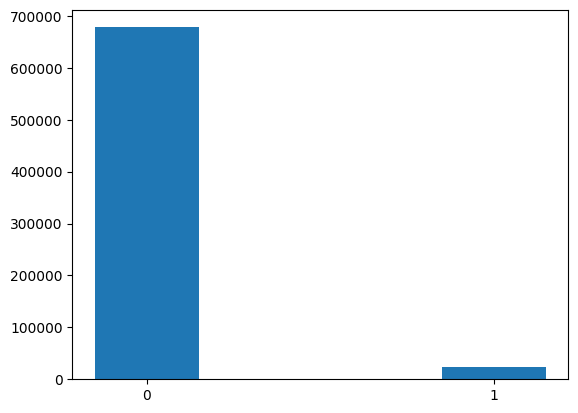

In [30]:
plt.bar([0,1],[labels_count[0], labels_count[1]], width=[0.3,0.3])
plt.xticks([0,1])

### Training

In [31]:
seed = 131
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [35]:
optimizer = optim.Adam(keyword_predictor.parameters(), lr=1e-6)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay_rate)

batch_losses = []
validation_losses_record = []
global_step = 0
writer = SummaryWriter('./runs/{}'.format(save_name))

global_step = 0
down_sampling = True

for epoch in range(100):
    keyword_predictor.train()

    pbar = tqdm(train_dataloader)
    epoch_average_loss = 0
    epoch_batch_loss = []
    for step, batch in enumerate(pbar):
        optimizer.zero_grad()

        states = batch['state']
        labels = batch['labels']
        edge_indices = batch['edge_index']
        labels = [label.clone().type(torch.LongTensor).cuda() for label in labels]

        losses = []
        for i in range(len(states)):
            label = labels[i]
            state = states[i]
            edge_index = edge_indices[i]

            output = keyword_predictor(state, edge_index).reshape(-1)

            masked = (label != -1)
            output = output[masked]
            label = label[masked]

            cross_entropy_loss = keyword_predictor.loss_func(output, label.float())
            losses.append(cross_entropy_loss)

        loss = sum(losses)
        # loss = torch.div(sum(losses), batch_size)

        loss.backward()
        optimizer.step()

        epoch_batch_loss.append(loss.item())
        pbar.set_description('[epoch: {}, step: {}] loss={}'.format(epoch, step, loss.item()/batch_size))
        writer.add_scalar('loss/batch', loss.item()/batch_size, global_step)
        global_step += 1
    batch_losses.extend(epoch_batch_loss)

    # validation loss
    validation_losses = []
    acc_list = {5:[], 10: [], 15: [], 20: [], 25: [], 30: [], 35: []}
    k_list = [5,10,15,20,25, 30, 35]
    all_true_labels = []
    all_predicted_labels = []
    for batch in tqdm(valid_dataloader):
        states = batch['state']
        labels = batch['labels']
        edge_indices = batch['edge_index']
        node_lists = [np.array(node_list) for node_list in batch['node_lists']]
        labels = [label.clone().long() for label in labels]

        for i in range(len(states)):
            output = keyword_predictor.predict(states[i], edge_indices[i]).reshape(-1)
            label = labels[i]
            masked = (label != -1)
            output = output[masked]
            label = label[masked]
            node_list = node_lists[i][masked.cpu().detach().numpy()]

            cross_entropy_loss = keyword_predictor.loss_func(output, label.float())
            validation_losses.append(cross_entropy_loss)

            predicted_labels = (output > 0.5)
            predicted_labels = predicted_labels.float()

            all_true_labels.extend(label.cpu().detach().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().detach().numpy())

            for k in k_list:
                top_k_output = torch.topk(output, k=min(k, output.size(0)))
                top_k_indices = top_k_output.indices
                top_k_values = top_k_output.values

                predicted_words = node_list[top_k_indices.cpu().numpy()]
                actual_words = node_list[(label==1).cpu().numpy()]

                acc = len(set(predicted_words) & set(actual_words)) / len(actual_words)
                acc_list[k].append(acc)

    print('top k acc')
    acc_list_str = {}
    for k in k_list:
        acc_list_str[str(k)] = acc_list[k]
        print('top {} acc: {}'.format(k, sum(acc_list[k])/len(acc_list[k])))

    train_average_loss = sum(epoch_batch_loss)/len(epoch_batch_loss)
    validation_loss = sum(validation_losses) / len(validation_losses)
    validation_losses_record.append(validation_loss)

    print('epoch: {}, train loss: {}'.format(epoch, train_average_loss/batch_size))
    print('epoch: {}, valid loss: {}'.format(epoch, validation_loss))
    print()

    writer.add_scalars('loss/epoch', {'train': train_average_loss, 'valid': validation_loss}, epoch)
    if (epoch+1) % 5 == 0:
        torch.save(keyword_predictor.state_dict(), './model/{}/model_epoch{}.pth'.format(save_name, epoch+1))

100%|██████████| 174/174 [00:08<00:00, 19.73it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.25392136681762045
top 10 acc: 0.3858412240977084
top 15 acc: 0.4731130780842598
top 20 acc: 0.5394675449430497
top 25 acc: 0.5949910800054896
top 30 acc: 0.6424454508028
top 35 acc: 0.6841361328393034
epoch: 0, train loss: 1.8377561277658994
epoch: 0, valid loss: 1.6335724592208862



100%|██████████| 174/174 [00:08<00:00, 21.05it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26016536297516135
top 10 acc: 0.3886029916289285
top 15 acc: 0.47075957184026346
top 20 acc: 0.5406683134348841
top 25 acc: 0.5965520790448745
top 30 acc: 0.6468642788527516
top 35 acc: 0.6835357485933856
epoch: 1, train loss: 1.528412752332603
epoch: 1, valid loss: 1.4638350009918213



100%|██████████| 174/174 [00:08<00:00, 21.41it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.25757170303279814
top 10 acc: 0.3902120214079868
top 15 acc: 0.4712398792369975
top 20 acc: 0.5395876217922329
top 25 acc: 0.5987614930698508
top 30 acc: 0.6445828187182657
top 35 acc: 0.6817345958556336
epoch: 2, train loss: 1.4354615827896586
epoch: 2, valid loss: 1.4172108173370361



100%|██████████| 174/174 [00:08<00:00, 21.16it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.25901262522299995
top 10 acc: 0.3899718677096201
top 15 acc: 0.4729209551255661
top 20 acc: 0.5397076986414162
top 25 acc: 0.5993618773157677
top 30 acc: 0.6453032798133662
top 35 acc: 0.6821668725126938
epoch: 3, train loss: 1.411088368253501
epoch: 3, valid loss: 1.4050191640853882



100%|██████████| 174/174 [00:08<00:00, 20.91it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.25901262522299995
top 10 acc: 0.3904041443666803
top 15 acc: 0.4722004940304651
top 20 acc: 0.5397076986414161
top 25 acc: 0.5982811856731165
top 30 acc: 0.6460717716481404
top 35 acc: 0.682166872512694
epoch: 4, train loss: 1.4042924644000276
epoch: 4, valid loss: 1.4013603925704956



100%|██████████| 174/174 [00:07<00:00, 22.17it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.25997324001646765
top 10 acc: 0.3911726362014547
top 15 acc: 0.47248867846850573
top 20 acc: 0.5392273912446823
top 25 acc: 0.5982811856731165
top 30 acc: 0.6477528475367093
top 35 acc: 0.6830794565664883
epoch: 5, train loss: 1.40148644875196
epoch: 5, valid loss: 1.3994446992874146



100%|██████████| 174/174 [00:07<00:00, 21.99it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26009331686565124
top 10 acc: 0.39117263620145465
top 15 acc: 0.4706154796212435
top 20 acc: 0.5392273912446827
top 25 acc: 0.5995299849046247
top 30 acc: 0.648953616028544
top 35 acc: 0.6826471799094279
epoch: 6, train loss: 1.3996405827175
epoch: 6, valid loss: 1.3981759548187256



100%|██████████| 174/174 [00:08<00:00, 21.44it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26117400850830264
top 10 acc: 0.3910525593522712
top 15 acc: 0.47061547962124317
top 20 acc: 0.539227391244682
top 25 acc: 0.6016913681899274
top 30 acc: 0.648953616028544
top 35 acc: 0.6840881020996294
epoch: 7, train loss: 1.3980598413412402
epoch: 7, valid loss: 1.3970606327056885



100%|██████████| 174/174 [00:08<00:00, 21.23it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26261493069850417
top 10 acc: 0.39249348154247315
top 15 acc: 0.46917455743104164
top 20 acc: 0.5392273912446823
top 25 acc: 0.603492520927679
top 30 acc: 0.6496260463839714
top 35 acc: 0.6873301770275833
epoch: 8, train loss: 1.3965963659466654
epoch: 8, valid loss: 1.3960341215133667



100%|██████████| 174/174 [00:07<00:00, 21.92it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2640558528887059
top 10 acc: 0.3921332509949225
top 15 acc: 0.4691745574310417
top 20 acc: 0.5395155756827232
top 25 acc: 0.6034925209276798
top 30 acc: 0.6496260463839717
top 35 acc: 0.6873301770275836
epoch: 9, train loss: 1.3951637252230928
epoch: 9, valid loss: 1.3950504064559937



100%|██████████| 174/174 [00:09<00:00, 18.20it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2643440373267465
top 10 acc: 0.39285371209002334
top 15 acc: 0.4691745574310417
top 20 acc: 0.5395155756827227
top 25 acc: 0.6037807053657198
top 30 acc: 0.6496260463839716
top 35 acc: 0.6882907918210512
epoch: 10, train loss: 1.3937759054794763
epoch: 10, valid loss: 1.3940842151641846



100%|██████████| 174/174 [00:08<00:00, 21.62it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26458419102511327
top 10 acc: 0.39458281871826545
top 15 acc: 0.4691745574310418
top 20 acc: 0.539995883079457
top 25 acc: 0.6037807053657201
top 30 acc: 0.6481851241937702
top 35 acc: 0.6885309455194185
epoch: 11, train loss: 1.3924300762378519
epoch: 11, valid loss: 1.3931607007980347



100%|██████████| 174/174 [00:08<00:00, 21.26it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.263503499382462
top 10 acc: 0.3945828187182656
top 15 acc: 0.4695347879785923
top 20 acc: 0.5404761904761907
top 25 acc: 0.6037807053657198
top 30 acc: 0.649265815836421
top 35 acc: 0.6894435295732123
epoch: 12, train loss: 1.391107434221211
epoch: 12, valid loss: 1.3922529220581055



100%|██████████| 174/174 [00:22<00:00,  7.71it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26302319198572804
top 10 acc: 0.39638397145601756
top 15 acc: 0.469534787978592
top 20 acc: 0.5408364210237407
top 25 acc: 0.6030602442706189
top 30 acc: 0.6507067380266229
top 35 acc: 0.6899238369699466
epoch: 13, train loss: 1.3898165139139083
epoch: 13, valid loss: 1.3913859128952026



100%|██████████| 174/174 [00:08<00:00, 19.94it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26326334568409493
top 10 acc: 0.3963839714560176
top 15 acc: 0.4698950185261425
top 20 acc: 0.5408364210237412
top 25 acc: 0.6041409359132706
top 30 acc: 0.650706738026623
top 35 acc: 0.6913647591601485
epoch: 14, train loss: 1.388569992754333
epoch: 14, valid loss: 1.3905304670333862



100%|██████████| 174/174 [00:14<00:00, 12.26it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26326334568409504
top 10 acc: 0.39739261698915856
top 15 acc: 0.46845409633594054
top 20 acc: 0.5449190338959791
top 25 acc: 0.6037807053657196
top 30 acc: 0.6507067380266229
top 35 acc: 0.6918450665568822
epoch: 15, train loss: 1.3873518821199415
epoch: 15, valid loss: 1.3896749019622803



100%|██████████| 174/174 [00:08<00:00, 21.43it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2615822697955264
top 10 acc: 0.3971524632907919
top 15 acc: 0.4689344037326744
top 20 acc: 0.5449190338959787
top 25 acc: 0.6042610127624538
top 30 acc: 0.6526279676135588
top 35 acc: 0.6918450665568825
epoch: 16, train loss: 1.3861593737048352
epoch: 16, valid loss: 1.388878345489502



100%|██████████| 174/174 [00:13<00:00, 13.34it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2615822697955263
top 10 acc: 0.39715246329079207
top 15 acc: 0.46893440373267475
top 20 acc: 0.5455674488815699
top 25 acc: 0.6047413201591876
top 30 acc: 0.6531082750102921
top 35 acc: 0.6929257581995332
epoch: 17, train loss: 1.3849932288217965
epoch: 17, valid loss: 1.3880808353424072



100%|██████████| 174/174 [00:08<00:00, 21.70it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2608618087004257
top 10 acc: 0.397152463290792
top 15 acc: 0.4718162481130781
top 20 acc: 0.54556744888157
top 25 acc: 0.6050295045972282
top 30 acc: 0.6550295045972282
top 35 acc: 0.6941265266913682
epoch: 18, train loss: 1.3838518422899522
epoch: 18, valid loss: 1.3873035907745361



100%|██████████| 174/174 [00:07<00:00, 22.08it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2608618087004255
top 10 acc: 0.3971524632907922
top 15 acc: 0.47325717030328
top 20 acc: 0.5449670646356525
top 25 acc: 0.605797996432002
top 30 acc: 0.6555098119939616
top 35 acc: 0.6936462192946343
epoch: 19, train loss: 1.3827301438334862
epoch: 19, valid loss: 1.3865431547164917



100%|██████████| 174/174 [00:07<00:00, 22.43it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2608618087004254
top 10 acc: 0.397152463290792
top 15 acc: 0.473785508439687
top 20 acc: 0.5483292164127899
top 25 acc: 0.6063983806779196
top 30 acc: 0.6555098119939619
top 35 acc: 0.6936462192946343
epoch: 20, train loss: 1.3816337945760255
epoch: 20, valid loss: 1.3857921361923218



100%|██████████| 174/174 [00:07<00:00, 22.24it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26086180870042536
top 10 acc: 0.3971524632907919
top 15 acc: 0.47378550843968736
top 20 acc: 0.5497701386029916
top 25 acc: 0.6063983806779195
top 30 acc: 0.6569507341841635
top 35 acc: 0.6938863729930013
epoch: 21, train loss: 1.3805581721629936
epoch: 21, valid loss: 1.3850791454315186



100%|██████████| 174/174 [00:07<00:00, 22.26it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26206257719226017
top 10 acc: 0.39715246329079207
top 15 acc: 0.4737855084396875
top 20 acc: 0.5497701386029921
top 25 acc: 0.606878688074654
top 30 acc: 0.6569507341841638
top 35 acc: 0.6946068340881023
epoch: 22, train loss: 1.3795051660712125
epoch: 22, valid loss: 1.3843809366226196



100%|██████████| 174/174 [00:07<00:00, 22.17it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26206257719226045
top 10 acc: 0.3978729243858926
top 15 acc: 0.4733772471524634
top 20 acc: 0.5502504459997256
top 25 acc: 0.6056779195828189
top 30 acc: 0.6572389186222041
top 35 acc: 0.694606834088102
epoch: 23, train loss: 1.3784619899903847
epoch: 23, valid loss: 1.383681297302246



100%|██████████| 174/174 [00:07<00:00, 21.86it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2620625771922602
top 10 acc: 0.39811307808425983
top 15 acc: 0.473857554549197
top 20 acc: 0.5502504459997255
top 25 acc: 0.6061582269795526
top 30 acc: 0.656518457527103
top 35 acc: 0.6946068340881021
epoch: 24, train loss: 1.3774436962374537
epoch: 24, valid loss: 1.3829996585845947



100%|██████████| 174/174 [00:08<00:00, 21.73it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26242280773981075
top 10 acc: 0.3994339234252778
top 15 acc: 0.4738575545491971
top 20 acc: 0.5502504459997256
top 25 acc: 0.6061582269795529
top 30 acc: 0.6572389186222041
top 35 acc: 0.6966481405242216
epoch: 25, train loss: 1.376434530715467
epoch: 25, valid loss: 1.3823128938674927



100%|██████████| 174/174 [00:07<00:00, 21.98it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26170234664470965
top 10 acc: 0.3999142308220121
top 15 acc: 0.47241663235899534
top 20 acc: 0.5513311376423768
top 25 acc: 0.606158226979553
top 30 acc: 0.6572389186222042
top 35 acc: 0.6966481405242215
epoch: 26, train loss: 1.3754508059795263
epoch: 26, valid loss: 1.3816674947738647



100%|██████████| 174/174 [00:08<00:00, 21.69it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.260981885549609
top 10 acc: 0.39991423082201194
top 15 acc: 0.4733772471524632
top 20 acc: 0.5522917524358445
top 25 acc: 0.6069987649238371
top 30 acc: 0.6583196102648555
top 35 acc: 0.6973686016193223
epoch: 27, train loss: 1.374473033706475
epoch: 27, valid loss: 1.3810176849365234



100%|██████████| 174/174 [00:07<00:00, 22.35it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26146219294634293
top 10 acc: 0.39991423082201183
top 15 acc: 0.4743378619459312
top 20 acc: 0.5531322903801292
top 25 acc: 0.6074790723205709
top 30 acc: 0.6583196102648555
top 35 acc: 0.6973686016193223
epoch: 28, train loss: 1.3734969274407414
epoch: 28, valid loss: 1.3803834915161133



100%|██████████| 174/174 [00:07<00:00, 21.88it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2614621929463429
top 10 acc: 0.39991423082201194
top 15 acc: 0.4738575545491971
top 20 acc: 0.5538527514752298
top 25 acc: 0.6094003019075066
top 30 acc: 0.6587999176615894
top 35 acc: 0.6973686016193223
epoch: 29, train loss: 1.3725659863789748
epoch: 29, valid loss: 1.3797463178634644



100%|██████████| 174/174 [00:07<00:00, 22.08it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2614621929463429
top 10 acc: 0.39991423082201194
top 15 acc: 0.47337724715246343
top 20 acc: 0.55385275147523
top 25 acc: 0.6101207630026073
top 30 acc: 0.6587999176615891
top 35 acc: 0.6971284479209552
epoch: 30, train loss: 1.3716169897215351
epoch: 30, valid loss: 1.3791390657424927



100%|██████████| 174/174 [00:13<00:00, 13.29it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2621826540414437
top 10 acc: 0.39919376972691106
top 15 acc: 0.47385755454919715
top 20 acc: 0.55421298202278
top 25 acc: 0.6106010703993412
top 30 acc: 0.6595203787566901
top 35 acc: 0.6971284479209553
epoch: 31, train loss: 1.3706699397259203
epoch: 31, valid loss: 1.3785252571105957



100%|██████████| 174/174 [00:13<00:00, 13.32it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2621826540414438
top 10 acc: 0.3991937697269109
top 15 acc: 0.47385755454919715
top 20 acc: 0.5542129820227809
top 25 acc: 0.6106010703993417
top 30 acc: 0.6595203787566906
top 35 acc: 0.6971284479209554
epoch: 32, train loss: 1.3697417633805629
epoch: 32, valid loss: 1.3778889179229736



100%|██████████| 174/174 [00:13<00:00, 12.96it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2617023466447098
top 10 acc: 0.39919376972691123
top 15 acc: 0.47385755454919726
top 20 acc: 0.5542129820227807
top 25 acc: 0.6125222999862773
top 30 acc: 0.6591601482091397
top 35 acc: 0.6978489090160563
epoch: 33, train loss: 1.368834455260989
epoch: 33, valid loss: 1.3772807121276855



100%|██████████| 174/174 [00:14<00:00, 12.12it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2624228077398105
top 10 acc: 0.39919376972691106
top 15 acc: 0.4736174008508301
top 20 acc: 0.5534925209276794
top 25 acc: 0.612522299986277
top 30 acc: 0.6587999176615892
top 35 acc: 0.6985693701111569
epoch: 34, train loss: 1.3679183518627833
epoch: 34, valid loss: 1.3766926527023315



100%|██████████| 174/174 [00:13<00:00, 13.27it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2624228077398108
top 10 acc: 0.3991937697269109
top 15 acc: 0.47469809249348166
top 20 acc: 0.5542129820227804
top 25 acc: 0.6128825305338275
top 30 acc: 0.6580794565664884
top 35 acc: 0.6978489090160562
epoch: 35, train loss: 1.3670267399843674
epoch: 35, valid loss: 1.3760875463485718



100%|██████████| 174/174 [00:13<00:00, 12.93it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26242280773981075
top 10 acc: 0.39919376972691106
top 15 acc: 0.4746980924934815
top 20 acc: 0.5549814738575546
top 25 acc: 0.612522299986277
top 30 acc: 0.6597605324550572
top 35 acc: 0.699049677507891
epoch: 36, train loss: 1.3661448143278863
epoch: 36, valid loss: 1.3754998445510864



100%|██████████| 174/174 [00:13<00:00, 12.52it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2631432688349115
top 10 acc: 0.39955400027446175
top 15 acc: 0.4746980924934815
top 20 acc: 0.5561822423493894
top 25 acc: 0.6139632221764788
top 30 acc: 0.6597605324550572
top 35 acc: 0.699049677507891
epoch: 37, train loss: 1.3652704383016017
epoch: 37, valid loss: 1.374894142150879



100%|██████████| 174/174 [00:13<00:00, 12.59it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26314326883491157
top 10 acc: 0.40003430767119513
top 15 acc: 0.47541855358858265
top 20 acc: 0.5561822423493894
top 25 acc: 0.6146836832715797
top 30 acc: 0.6604809935501581
top 35 acc: 0.6995299849046248
epoch: 38, train loss: 1.3643914417175043
epoch: 38, valid loss: 1.3743247985839844



100%|██████████| 174/174 [00:13<00:00, 12.46it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2633491148620832
top 10 acc: 0.4000343076711954
top 15 acc: 0.4754185535885825
top 20 acc: 0.5565424728969403
top 25 acc: 0.6146836832715796
top 30 acc: 0.6612014546452586
top 35 acc: 0.6995299849046245
epoch: 39, train loss: 1.363530845156724
epoch: 39, valid loss: 1.3737573623657227



100%|██████████| 174/174 [00:12<00:00, 13.47it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2644298065047345
top 10 acc: 0.40003430767119547
top 15 acc: 0.475778784136133
top 20 acc: 0.5576231645395912
top 25 acc: 0.6171332509949229
top 30 acc: 0.6609132702072186
top 35 acc: 0.6995299849046247
epoch: 40, train loss: 1.3626832320112316
epoch: 40, valid loss: 1.3731831312179565



100%|██████████| 174/174 [00:13<00:00, 13.34it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2644298065047344
top 10 acc: 0.40099492246466323
top 15 acc: 0.475778784136133
top 20 acc: 0.5587038561822423
top 25 acc: 0.6171332509949226
top 30 acc: 0.6630746534925211
top 35 acc: 0.7007307533964597
epoch: 41, train loss: 1.3618317843202226
epoch: 41, valid loss: 1.3726072311401367



100%|██████████| 174/174 [00:16<00:00, 10.27it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2649101139014684
top 10 acc: 0.4009949224646634
top 15 acc: 0.47721970632633476
top 20 acc: 0.5594243172773432
top 25 acc: 0.6185741731851241
top 30 acc: 0.6630746534925209
top 35 acc: 0.7012110607931934
epoch: 42, train loss: 1.3609843386091602
epoch: 42, valid loss: 1.3720324039459229



100%|██████████| 174/174 [00:13<00:00, 13.18it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.26620694387265004
top 10 acc: 0.4002744613695622
top 15 acc: 0.47721970632633437
top 20 acc: 0.5594243172773434
top 25 acc: 0.6185741731851243
top 30 acc: 0.6641553451351725
top 35 acc: 0.7012110607931937
epoch: 43, train loss: 1.3601469566680227
epoch: 43, valid loss: 1.3714834451675415



100%|██████████| 174/174 [00:13<00:00, 12.46it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2654864827775492
top 10 acc: 0.40027446136956213
top 15 acc: 0.4783003979689855
top 20 acc: 0.559424317277343
top 25 acc: 0.6192946342802249
top 30 acc: 0.6641553451351724
top 35 acc: 0.7012110607931937
epoch: 44, train loss: 1.3593217428426267
epoch: 44, valid loss: 1.3709299564361572



100%|██████████| 174/174 [00:13<00:00, 12.73it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2669274049677509
top 10 acc: 0.4002744613695622
top 15 acc: 0.4787807053657196
top 20 acc: 0.560625085769178
top 25 acc: 0.6189344037326747
top 30 acc: 0.6646356525319062
top 35 acc: 0.7012110607931936
epoch: 45, train loss: 1.3585064422183482
epoch: 45, valid loss: 1.3703930377960205



100%|██████████| 174/174 [00:12<00:00, 13.50it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2669274049677509
top 10 acc: 0.3997941539728284
top 15 acc: 0.47914093591327017
top 20 acc: 0.5615857005626457
top 25 acc: 0.6189344037326745
top 30 acc: 0.6646356525319062
top 35 acc: 0.7012110607931934
epoch: 46, train loss: 1.3576892045868554
epoch: 46, valid loss: 1.3698394298553467



100%|██████████| 174/174 [00:14<00:00, 11.99it/s]


[[47541     0]
 [ 1638     0]]
top k acc
top 5 acc: 0.2678880197612185
top 10 acc: 0.3988335391793607
top 15 acc: 0.4791409359132703
top 20 acc: 0.5619459311101963
top 25 acc: 0.6189344037326747
top 30 acc: 0.6651159599286403
top 35 acc: 0.7016913681899274
epoch: 47, train loss: 1.3568929604275626
epoch: 47, valid loss: 1.3692898750305176



 56%|█████▋    | 98/174 [00:13<00:10,  7.08it/s]


KeyboardInterrupt: 

In [ ]:
epoch_loss_length = int(len(batch_losses) / epochs)
mean_loss = [np.mean(batch_losses[epoch_loss_length*i:epoch_loss_length*(i+1)]) for i in range(epochs)]
std_loss = [np.std(batch_losses[epoch_loss_length*i:epoch_loss_length*(i+1)]) for i in range(epochs)]
plt.plot(range(1,26), mean_loss[1:26], label='train')
plt.plot(range(1,26), [n.cpu().numpy() for n in validation_losses_record][:25],label='valid')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(16,9))
batch_losses = np.array(batch_losses)
plt.plot(np.arange(len(batch_losses)), np.array(batch_losses)/batch_size, label='train')
plt.show()

## Evaluation

In [ ]:
multi_label_acc_list = []

all_true_labels = []
all_predicted_labels = []

acc_list = {5:[], 10: [], 15: [], 20: [], 25: [], 30: [], 35: []}
k_list = [5,10,15,20,25, 30, 35]

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for batch in tqdm(valid_dataloader):
    states = batch['state']
    node_lists = [np.array(node_list) for node_list in batch['node_lists']]
    labels = batch['labels']

    for i in range(len(states)):
        output = keyword_predictor.predict(states[i])
        node_list = node_lists[i]
        label = labels[i]
        label_weight = (labels[i] != -1).float()
        label_weight = label_weight.reshape(-1, 1)

        predicted_labels = []
        for threshold in thresholds:
            predicted_label = (output > threshold).float()
            predicted_label[(label==-1)] = -1
            predicted_label = predicted_label.cpu().numpy().tolist()
            predicted_labels.append(predicted_label)
        label = labels[i].cpu().numpy().tolist()

        all_true_labels.extend(label)
        all_predicted_labels.append(predicted_labels)

        output = output * label_weight

        output = output.reshape(-1)
        top_k_output = torch.topk(output, k=5)
        top_k_indices = top_k_output.indices
        top_k_values = top_k_output.values

        predicted_words = node_list[top_k_indices.cpu().numpy()]
        print(predicted_words)
        actual_words = node_list[(labels[i]==1).cpu().numpy()]
        print(actual_words)

        acc = len(set(predicted_words) & set(actual_words)) / len(actual_words)
        acc_list[k].append(acc)

In [ ]:
predicted_label_dict = {0.1: [], 0.2: [], 0.3: [], 0.4: [], 0.5: [], 0.6: [], 0.7: [], 0.8: [], 0.9: []}
for i in range(len(all_predicted_labels)):
    for j in range(len(all_predicted_labels[0])):
        predicted_label_dict[thresholds[j]].extend(all_predicted_labels[i][j])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for threshold in thresholds:
    cm = confusion_matrix(y_true=all_true_labels, y_pred=predicted_label_dict[threshold])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[1:, 1:], display_labels=[0,1])
    disp.plot(cmap = 'Blues')
    plt.title('threshold={}'.format(threshold))
    plt.legend()
    plt.show()

In [ ]:
for k in k_list:
    print('top {} acc: {}'.format(k, sum(acc_list[k])/len(acc_list[k])))